# 아이템기반 추천시스템 (surprise)

## 데이터셋 구축

In [ ]:
pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 KB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp38-cp38-linux_x86_64.whl size=2626474 sha256=15333d00ce8331758e674a3d803e5cf563c39fdd07dfcde2642c11c6bf9ae82e
  Stored in directory: /root/.cache/pip/wheels/af/db/86/2c18183a80ba05da35bf0fb7417aac5cddbd93bcb1b92fd3ea
Successfully built scikit-surprise


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import statistics

from surprise import SVD
from surprise import Dataset, Reader
from surprise import accuracy 
from surprise.model_selection import train_test_split

%matplotlib inline

from sklearn.metrics.pairwise import cosine_similarity
import operator

In [ ]:
df_merchant_cl_origin = pd.read_csv('/content/drive/MyDrive/데이터분석/2차_프로젝트_lmemdata/5팀_공유폴더/작업결과물/recommandations/df_merchant_cl.csv')

In [ ]:
df_purchase_tr = pd.read_csv('/content/drive/MyDrive/데이터분석/2차_프로젝트_lmemdata/5팀_공유폴더/작업결과물/dataset/lmemdata/구매상품TR.txt', encoding='cp949', chunksize = 1000000) #100만개 단위로 끊기, 실제 transaction 데이터
chunk = list(df_purchase_tr)

print(len(chunk)) # 몇개 chunk인지 출력

df_purchase_tr = pd.concat(chunk)  # 데이터 넣기
df_purchase_tr.shape
# df_purchase_tr['구매일자'] = pd.to_datetime(df_purchase_tr['구매일자'],format='%Y%m%d')
df_purchase_tr

29


,제휴사,영수증번호,대분류코드,중분류코드,소분류코드,고객번호,점포코드,구매일자,구매시간,구매금액
0,B,8664000,15,1504,B150401,17218,44,20140222,20,2420
1,B,8664000,16,1601,B160101,17218,44,20140222,20,1070
2,B,8664000,16,1602,B160201,17218,44,20140222,20,8060
3,B,8664000,18,1803,B180301,17218,44,20140222,20,6000
4,B,8664001,5,509,B050901,17674,44,20140222,22,1120
...,...,...,...,...,...,...,...,...,...,...
28593025,B,8116737,37,3709,B370904,7439,29,20150525,19,14000
28593026,B,8116738,37,3709,B370904,16421,29,20150525,20,6500
28593027,B,8116739,8,802,B080203,8266,29,20150525,13,16000
28593028,B,8116764,90,9001,B900103,14316,29,20150526,19,1000


In [ ]:
# 새로 분류한 중분류코드 종합

path = '/content/drive/MyDrive/데이터분석/2차_프로젝트_lmemdata/5팀_공유폴더/작업결과물/dataset/create_feature/'
cat_a_df = df_merchant_cl_origin[df_merchant_cl_origin.제휴사 == 'A'] 


### 피클 파일 불러오기 ###
import pickle

with open(path + "중분류코드_종합.pkl","rb") as f:
  new_cat_df=pickle.load(f);

# 빈 value의 경우 key값을 value값으로 받아오기
dct = {k: [k] if v == [] else v for k, v in new_cat_df.items() }

# key와 value swap
newDict = {}
for key,value in dct.items():
    for val in value:
        if val in newDict:
            newDict[val].append(key)
        else:
            newDict[val] = [key]

# A 제휴사 분류를 추가
newDict_ = {}
for i in cat_a_df.중분류명:
  newDict_[i] = i

newDict.update(newDict_)

# 빠진거 추가
newDict['전통과자'] = 'N스낵류'
newDict['간편간식'] = 'N스낵류'

#리스트(이지만 하나의 member만 가짐)를 str로 변경
prod_Dict = {}
for key,value in newDict.items():
  if type(value) == list :
    prod_Dict[key] = value[0]
  else :
    prod_Dict[key] = value

df_merchant_cl_origin['new_mid_cat'] = df_merchant_cl_origin['중분류명'].apply(lambda x : prod_Dict[x])

df_merchant_cl_origin.head()

,Unnamed: 0,제휴사,대분류코드,중분류코드,소분류코드,중분류명,소분류명,분류,고급/일반,내구/준내구/비내구,편의/선매/전문,new_mid_cat
0,0,A,1,101,A010101,일용잡화,위생세제,일용잡화,일반,내구,편의,일용잡화
1,1,A,1,101,A010102,일용잡화,휴지류,일용잡화,일반,내구,편의,일용잡화
2,2,A,1,101,A010103,일용잡화,뷰티상품,일용잡화,일반,내구,편의,일용잡화
3,3,A,1,101,A010104,일용잡화,일용잡화,일용잡화,일반,내구,편의,일용잡화
4,4,A,1,101,A010105,일용잡화,세트상품,일용잡화,일반,내구,편의,일용잡화


##A제휴사 전문상품 추천시스템

###데이터 준비

In [ ]:
# A 제휴사 전문 상품
df_merchant_cl = df_merchant_cl_origin[df_merchant_cl_origin['제휴사']=='A']
df_merchant_cl = df_merchant_cl[df_merchant_cl['중분류명'].isin(['건강식품', '디자이너', '명품', '모피/피혁', '보석', '악기', '준보석/시계'])]
df_merchant_cl = df_merchant_cl.drop('Unnamed: 0', axis=1)
df_merchant_cl.head()

,제휴사,대분류코드,중분류코드,소분류코드,중분류명,소분류명,분류,고급/일반,내구/준내구/비내구,편의/선매/전문,new_mid_cat
1631,A,1,108,A010801,건강식품,건강식품(홍삼),건강식품,고급,비내구,전문,건강식품
1632,A,1,108,A010802,건강식품,건강식품,건강식품,고급,비내구,전문,건강식품
1633,A,1,108,A010803,건강식품,건강식품(비타민),건강식품,고급,비내구,전문,건강식품
2194,A,2,204,A020401,보석,조화,보석,고급,내구,전문,보석
2195,A,2,204,A020402,보석,보석,보석,고급,내구,전문,보석


In [ ]:
surprise_df = df_purchase_tr[['고객번호','소분류코드','구매금액']].groupby(['고객번호','소분류코드']).count()
surprise_df.reset_index(inplace = True)
surprise_df.columns = ['고객번호','소분류코드',	'구매빈도']
surprise_df = pd.merge(surprise_df,df_merchant_cl[['소분류코드','소분류명']], on = '소분류코드', how = 'left')
surprise_df = surprise_df[['고객번호','소분류명','구매빈도']]

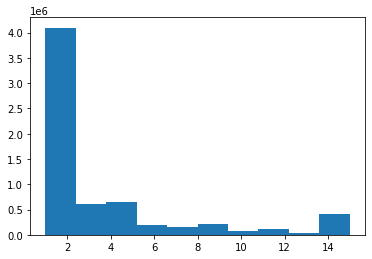

In [ ]:
plt.hist(surprise_df.구매빈도.clip(0,15));

In [ ]:
surprise_df.구매빈도.clip(0,15,inplace = True)

###전문 상품 추천

In [ ]:
reader = Reader(rating_scale = (0, 15)) # 최대 빈도수(rating) 30으로 설정
data = Dataset.load_from_df(surprise_df, reader = reader)

# 수행 시마다 동일하게 데이터를 분할하기 위해 random_state 값 부여
trainset, testset = train_test_split(data, test_size=.25, random_state=0) 

algo = SVD(random_state=0)
algo.fit(trainset) 

구매이력이 없는 리스트 추출하는 함수

In [ ]:
def get_unseen_surprise(surprise_df, userId):
    #입력값으로 들어온 userId에 해당하는 사용자가 평점을 매긴 모든 영화를 리스트로 생성
    seen_movies = surprise_df[surprise_df['고객번호']== userId]['소분류명'].tolist()
    
    # 모든 영화들의 movieId를 리스트로 생성. 
    total_movies = surprise_df['소분류명'].unique().tolist()
    
    # 모든 영화들의 movieId중 이미 평점을 매긴 영화의 movieId를 제외하여 리스트로 생성
    unseen_movies= [movie for movie in total_movies if movie not in seen_movies]
    print('구매 제품 수:',len(seen_movies), '비 구매 제품 수:',len(unseen_movies), \
          '전체 제품 수:',len(total_movies))
    
    return unseen_movies

unseen_movies = get_unseen_surprise(surprise_df, 9)

구매 제품 수: 108 비 구매 제품 수: 32 전체 제품 수: 39


추천제품 상위 10개 뽑는 함수

In [ ]:
def recomm_movie_by_surprise(algo, userId, unseen_movies, top_n=10):
    # 알고리즘 객체의 predict() 메서드를 평점이 없는 영화에 반복 수행한 후 결과를 list 객체로 저장
    predictions = [algo.predict(str(userId), movieId) for movieId in unseen_movies]    
    # predictions list 객체는 surprise의 Predictions 객체를 원소로 가지고 있음.
    # [Prediction(uid='9', iid='1', est=3.69), Prediction(uid='9', iid='2', est=2.98),,,,]
    # 이를 est 값으로 정렬하기 위해서 아래의 sortkey_est 함수를 정의함.
    # sortkey_est 함수는 list 객체의 sort() 함수의 키 값으로 사용되어 정렬 수행.
    def sortkey_est(pred):
        return pred.est
    
    # sortkey_est( ) 반환값의 내림 차순으로 정렬 수행하고 top_n개의 최상위 값 추출.
    predictions.sort(key=sortkey_est, reverse=True)
    top_predictions= predictions[:top_n]
    
    # top_n으로 추출된 영화의 정보 추출. 영화 아이디, 추천 예상 평점, 제목 추출
    top_movie_ids = [ pred.iid for pred in top_predictions]
    top_movie_rating = [ pred.est for pred in top_predictions]
    top_movie_titles = surprise_df[surprise_df.소분류명.isin(top_movie_ids)].소분류명.unique()
    top_movie_preds = [ (id, title, rating) for id, title, rating in zip(top_movie_ids, top_movie_titles, top_movie_rating)]
    
    return top_movie_preds

In [ ]:
clu0 = pd.read_csv('/content/drive/MyDrive/데이터분석/2차_프로젝트_lmemdata/5팀_공유폴더/작업결과물/clustering/data_clu0')
clu3 = pd.read_csv('/content/drive/MyDrive/데이터분석/2차_프로젝트_lmemdata/5팀_공유폴더/작업결과물/clustering/data_clu3')
clu0_li = clu0['고객번호'].unique().tolist()
clu3_li = clu3['고객번호'].unique().tolist()

In [ ]:
# 0번 그룹 A제휴사 전문 상품 추천
who = np.random.choice(clu0_li) # who는 고객번호
print('고객번호 :', who)

unseen_movies = get_unseen_surprise(surprise_df, who)
top_movie_preds = recomm_movie_by_surprise(algo, who, unseen_movies, top_n=10)
print('##### Top-10 추천 제품 리스트 #####')

for top_movie in top_movie_preds:
    print(top_movie[1], ":", top_movie[2])

print('='*30)
# 2015년 4분기 총구매금액
clu0['구매일자'] = pd.to_datetime(clu0['구매일자'],format='%Y-%m-%d')
temp = clu0[clu0['구매일자'].between('2015-10-01', '2015-12-31')]
total = temp[temp['고객번호']==who]['구매금액'].sum()

# 추천상품 구매 시 고객의 구매정보 예측
print('##### 지출증가 예측치 #####')
for i in range(10):
  recommandation = top_movie_preds[i][1]
  code = df_merchant_cl[df_merchant_cl['소분류명']==recommandation]['소분류코드'].values[0]
  outcome = df_purchase_tr[df_purchase_tr['소분류코드']==code]['구매금액'].mean()
  pred = (total + outcome)/total
  print(f'추천상품 (평균구매금액): {recommandation} ({outcome})', ', 예상지출증가율 :', pred*100-100)

고객번호 : 10577
구매 제품 수: 333 비 구매 제품 수: 32 전체 제품 수: 39
##### Top-10 추천 제품 리스트 #####
디자이너부틱 : 5.038579735822618
건강식품 : 4.443690415278115
수입의류 : 3.484216733535685
명품잡화 : 3.2995447581494077
global 편집샵 : 3.0287003241841215
디자이너 : 2.9428955027928247
남성해외패션 : 2.7807699838145115
주얼리멀티 : 2.707262660782355
디자이너캐릭터 : 2.706115237536897
엘리든 : 2.5777618711749373
##### 지출증가 예측치 #####
추천상품 (평균구매금액): 디자이너부틱 (671238.5039329861) , 예상지출증가율 : 8.827683351762559
추천상품 (평균구매금액): 건강식품 (109281.85613286949) , 예상지출증가율 : 1.4372024494741424
추천상품 (평균구매금액): 수입의류 (909098.6742925948) , 예상지출증가율 : 11.955862461911664
추천상품 (평균구매금액): 명품잡화 (1287546.8157574623) , 예상지출증가율 : 16.932961270070095
추천상품 (평균구매금액): global 편집샵 (67323.55917771561) , 예상지출증가율 : 0.8853947725767597
추천상품 (평균구매금액): 디자이너 (288174.9502789231) , 예상지출증가율 : 3.7898857054037904
추천상품 (평균구매금액): 남성해외패션 (933778.5038167939) , 예상지출증가율 : 12.280435201613855
추천상품 (평균구매금액): 주얼리멀티 (169818.18181818182) , 예상지출증가율 : 2.2333360313499213
추천상품 (평균구매금액): 디자이너캐릭터 (127786.66666666667) , 예상지

In [ ]:
# 3번 그룹 A제휴사 전문 상품 추천
import numpy as np
who = np.random.choice(clu3_li) # who는 고객번호
print('고객번호 :', who)

unseen_movies = get_unseen_surprise(surprise_df, who)
top_movie_preds = recomm_movie_by_surprise(algo, who, unseen_movies, top_n=10)
print('##### Top-10 추천 제품 리스트 #####')

for top_movie in top_movie_preds:
    print(top_movie[1], ":", top_movie[2])

print('='*30)

# 2015년 4분기 총구매금액
clu3['구매일자'] = pd.to_datetime(clu3['구매일자'],format='%Y-%m-%d')
temp = clu3[clu3['구매일자'].between('2015-10-01', '2015-12-31')]
total = temp[temp['고객번호']==who]['구매금액'].sum()

# 추천상품 구매 시 고객의 구매정보 예측
print('##### 지출증가 예측치 #####')
for i in range(10):
  recommandation = top_movie_preds[i][1]
  code = df_merchant_cl[df_merchant_cl['소분류명']==recommandation]['소분류코드'].values[0]
  outcome = df_purchase_tr[df_purchase_tr['소분류코드']==code]['구매금액'].mean()
  pred = (total + outcome)/total
  print(f'추천상품 (평균구매금액): {recommandation} ({outcome})', ', 예상지출증가율 :', pred*100-100)

고객번호 : 8066
구매 제품 수: 462 비 구매 제품 수: 38 전체 제품 수: 39
##### Top-10 추천 제품 리스트 #####
건강식품(홍삼) : 5.038579735822618
디자이너부틱 : 4.443690415278115
건강식품 : 4.306516019222889
건강식품(비타민) : 3.8641965800942626
수입의류 : 3.484216733535685
명품잡화 : 3.2995447581494077
어덜트 : 3.182746855347172
보석 : 3.064520036890415
global 편집샵 : 3.0287003241841215
주얼리멀티 : 2.9428955027928247
##### 지출증가 예측치 #####
추천상품 (평균구매금액): 건강식품(홍삼) (273813.0482442559) , 예상지출증가율 : 32.21807564936165
추천상품 (평균구매금액): 디자이너부틱 (671238.5039329861) , 예상지출증가율 : 78.98094352021428
추천상품 (평균구매금액): 건강식품 (109281.85613286949) , 예상지출증가율 : 12.858595054428008
추천상품 (평균구매금액): 건강식품(비타민) (73202.81793132683) , 예상지출증가율 : 8.613373033099819
추천상품 (평균구매금액): 수입의류 (909098.6742925948) , 예상지출증가율 : 106.96864173896304
추천상품 (평균구매금액): 명품잡화 (1287546.8157574623) , 예상지출증가율 : 151.49855340408843
추천상품 (평균구매금액): 어덜트 (783362.0239808153) , 예상지출증가율 : 92.17390154079493
추천상품 (평균구매금액): 보석 (1629220.8028357923) , 예상지출증가율 : 191.70145254894163
추천상품 (평균구매금액): global 편집샵 (67323.55917771561) , 예상지출증가율

In [ ]:
# 전체 데이터에 대한 추천 
# predictions = algo.test( testset )
# print('prediction type :',type(predictions), ' size:',len(predictions))
# print('prediction 결과의 최초 5개 추출')
# predictions[:5]

# # 사용자 아이디, 아이템 아이디는 문자열로 입력해야 함. 
# uid = str(196)
# iid = '넥타이'
# pred = algo.predict(uid, iid)
# print(pred)

# accuracy.rmse(predictions)

# # 교차검증
# from surprise.model_selection import cross_validate

# algo = SVD(random_state=0)
# cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

##B제휴사 편의(일반) 추천시스템

###데이터 준비

In [ ]:
# B 제휴사 편의
df_merchant_cl = df_merchant_cl_origin[df_merchant_cl_origin['제휴사']=='B']
df_merchant_cl = df_merchant_cl[df_merchant_cl['new_mid_cat'].isin(['육류', '일용잡화', '문구/팬시', '수산품', 'N냉동류',
                                                             'N냉장류', 'N스낵류', 'N음료류', 'N자동차용품', 'N푸드코트',
                                                             '가공식품', '농산물', 'N도서/음반', '생활잡화', '젓갈/반찬',
                                                             '주류', '차/커피', '축산가공'])]
df_merchant_cl = df_merchant_cl.drop('Unnamed: 0', axis=1)
df_merchant_cl.head()

,제휴사,대분류코드,중분류코드,소분류코드,중분류명,소분류명,분류,고급/일반,내구/준내구/비내구,편의/선매/전문,new_mid_cat
6,B,13,1304,B130401,담배,국산담배,일용잡화,일반,내구,편의,일용잡화
7,B,13,1304,B130402,담배,수입담배,일용잡화,일반,내구,편의,일용잡화
8,B,18,1801,B180101,기저귀,아기기저귀,일용잡화,일반,내구,편의,일용잡화
9,B,18,1801,B180102,기저귀,성인용기저귀,일용잡화,일반,내구,편의,일용잡화
10,B,18,1802,B180201,화장지,롤티슈,일용잡화,일반,내구,편의,일용잡화


In [ ]:
surprise_df = df_purchase_tr[['고객번호','소분류코드','구매금액']].groupby(['고객번호','소분류코드']).count()
surprise_df.reset_index(inplace = True)
surprise_df.columns = ['고객번호','소분류코드',	'구매빈도']
surprise_df = pd.merge(surprise_df,df_merchant_cl[['소분류코드','소분류명']], on = '소분류코드', how = 'left')
surprise_df = surprise_df[['고객번호','소분류명','구매빈도']]

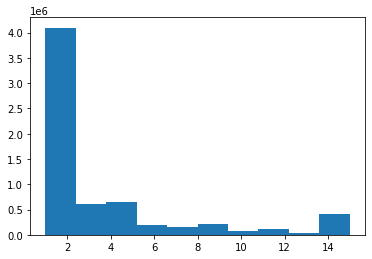

In [ ]:
import matplotlib.pyplot as plt
plt.hist(surprise_df.구매빈도.clip(0,15));

In [ ]:
surprise_df.구매빈도.clip(0,15,inplace = True)

###편의 상품 추천

In [ ]:
reader = Reader(rating_scale = (0, 15)) # 최대 빈도수(rating) 30으로 설정
data = Dataset.load_from_df(surprise_df, reader = reader)

# 수행 시마다 동일하게 데이터를 분할하기 위해 random_state 값 부여
trainset, testset = train_test_split(data, test_size=.25, random_state=0) 

algo = SVD(random_state=0)
algo.fit(trainset) 

In [ ]:
# 전체 데이터에 대한 추천 
# predictions = algo.test( testset )
# print('prediction type :',type(predictions), ' size:',len(predictions))
# print('prediction 결과의 최초 5개 추출')
# predictions[:5]

# # 사용자 아이디, 아이템 아이디는 문자열로 입력해야 함. 
# uid = str(196)
# iid = '넥타이'
# pred = algo.predict(uid, iid)
# print(pred)

# accuracy.rmse(predictions)

# # 교차검증
# from surprise.model_selection import cross_validate

# algo = SVD(random_state=0)
# cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

In [ ]:
# 0번 군집 B 제휴사 편의 상품 추천
who = np.random.choice(clu0_li) # who는 고객번호
print('고객번호 :', who)

unseen_movies = get_unseen_surprise(surprise_df, who)
top_movie_preds = recomm_movie_by_surprise(algo, who, unseen_movies, top_n=10)
print('##### Top-10 추천 제품 리스트 #####')

for top_movie in top_movie_preds:
    print(top_movie[1], ":", top_movie[2])

print('='*30)

# 2015년 4분기 총구매금액
clu0['구매일자'] = pd.to_datetime(clu0['구매일자'],format='%Y-%m-%d')
temp = clu0[clu0['구매일자'].between('2015-10-01', '2015-12-31')]
total = temp[temp['고객번호']==who]['구매금액'].sum()

# 추천상품 구매 시 고객의 구매정보 예측
print('##### 지출증가 예측치 #####')
for i in range(10):
  recommandation = top_movie_preds[i][1]
  code = df_merchant_cl[df_merchant_cl['소분류명']==recommandation]['소분류코드'].values[0]
  outcome = df_purchase_tr[df_purchase_tr['소분류코드']==code]['구매금액'].mean()
  pred = (total + outcome)/total
  print(f'추천상품 (평균구매금액): {recommandation} ({outcome})', ', 예상지출증가율 :', pred*100-100)

고객번호 : 16370
구매 제품 수: 343 비 구매 제품 수: 1403 전체 제품 수: 1514
##### Top-10 추천 제품 리스트 #####
기능성우유 : 6.798457343866663
부침두부 : 4.991654826383558
마시는요구르트 : 4.875984406563062
일반흰우유 : 4.836373327146546
국산콩나물 : 4.602245253879025
보네스빼 : 4.556736613086273
봉지면 : 4.50255856342054
NB돼지고기 : 4.467240249370265
일반닭 : 4.4467971909224016
기능성시유 : 4.431674554697352
##### 지출증가 예측치 #####
추천상품 (평균구매금액): 기능성우유 (4081.9152959190774) , 예상지출증가율 : 0.05301388358678594
추천상품 (평균구매금액): 부침두부 (2996.5155045944443) , 예상지출증가율 : 0.038917251488641114
추천상품 (평균구매금액): 마시는요구르트 (5743.746041897393) , 예상지출증가율 : 0.07459691393438561
추천상품 (평균구매금액): 일반흰우유 (4001.0065905869064) , 예상지출증가율 : 0.0519630816041996
추천상품 (평균구매금액): 국산콩나물 (1895.8714306923343) , 예상지출증가율 : 0.024622634238085084
추천상품 (평균구매금액): 보네스빼 (10356.818181818182) , 예상지출증가율 : 0.13450919816224882
추천상품 (평균구매금액): 봉지면 (8125.781803387213) , 예상지출증가율 : 0.1055336084526175
추천상품 (평균구매금액): NB돼지고기 (14210.848023430799) , 예상지출증가율 : 0.18456341892655814
추천상품 (평균구매금액): 일반닭 (7641.727351194586) , 예상지출증가율

구매이력이 없는 제품 중에, 구매한다면 어떤 평점을 줄까 하고 예측해서 높은 순으로.

#사용자기반 협업필터링 (cosine_similarity)

##B제휴사 편의(일반)상품 추천

In [ ]:
# B 제휴사 편의
df_merchant_cl = df_merchant_cl_origin[df_merchant_cl_origin['제휴사']=='B']
df_merchant_cl = df_merchant_cl[df_merchant_cl['new_mid_cat'].isin(['육류', '일용잡화', '문구/팬시', '수산품', 'N냉동류',
                                                             'N냉장류', 'N스낵류', 'N음료류', 'N자동차용품', 'N푸드코트',
                                                             '가공식품', '농산물', 'N도서/음반', '생활잡화', '젓갈/반찬',
                                                             '주류', '차/커피', '축산가공'])]
df_merchant_cl = df_merchant_cl.drop('Unnamed: 0', axis=1)
df_merchant_cl.head()

,제휴사,대분류코드,중분류코드,소분류코드,중분류명,소분류명,분류,고급/일반,내구/준내구/비내구,편의/선매/전문,new_mid_cat
6,B,13,1304,B130401,담배,국산담배,일용잡화,일반,내구,편의,일용잡화
7,B,13,1304,B130402,담배,수입담배,일용잡화,일반,내구,편의,일용잡화
8,B,18,1801,B180101,기저귀,아기기저귀,일용잡화,일반,내구,편의,일용잡화
9,B,18,1801,B180102,기저귀,성인용기저귀,일용잡화,일반,내구,편의,일용잡화
10,B,18,1802,B180201,화장지,롤티슈,일용잡화,일반,내구,편의,일용잡화


In [ ]:
surprise_df = df_purchase_tr[['고객번호','소분류코드','구매금액']].groupby(['고객번호','소분류코드']).count()
surprise_df.reset_index(inplace = True)
surprise_df.columns = ['고객번호','소분류코드',	'구매빈도']
surprise_df = pd.merge(surprise_df,df_merchant_cl[['소분류코드','소분류명']], on = '소분류코드', how = 'left')
surprise_df = surprise_df[['고객번호','소분류명','구매빈도']]

In [ ]:
surprise_df = surprise_df.dropna()
print(surprise_df.shape)
surprise_df.head()

(3378279, 3)


,고객번호,소분류명,구매빈도
127,1,기능성미,1
130,1,기능성우유,1
131,1,떠먹는요구르트,1
132,1,간장,1
133,1,포도씨유,1


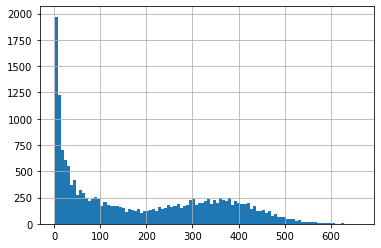

In [ ]:
rating_per_user = surprise_df.groupby('고객번호')['구매빈도'].count()

# 고객별 구매 제품 갯수
rating_per_user.hist(bins = 100);

In [ ]:
# 피벗테이블 만들기
rating_matrix = surprise_df.pivot_table(index='고객번호', columns='소분류명', values='구매빈도')

# 결측치 제거
rating_matrix = rating_matrix.fillna(0)
rating_matrix.shape

(18132, 1513)

In [ ]:
rating_matrix

소분류명,3분요리류,DVD,Digital Accessory,F/F기타,FAST FOOD,GAP감귤,HMR,Local갓,Local근대,Local기타잎채소,...,훈련,훈제/로스트,훈제계육,훈제구이진미,훈제오리,훼이셜클린져,휴대폰기타용품,휴지통,흑미류,흰다리새우
고객번호,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19379,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19380,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19381,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# 비슷한 성향의 고객 찾기 - 코사인 슈사도

def similar_users(user_id, matrix, k=5):
    # 현재 유저에 대한 데이터프레임 만들기
    # matrix의 index = user_id -> 현재 1명 유저에 대한 평가 정보 찾기
    user = matrix[matrix.index == user_id]
    
    # matrix index 값이 user_id와 다른가?
    # 일치하지 않는 값들은 other_users
    other_users = matrix[matrix.index != user_id]
    
    # 대상 user, 다른 유저와의 cosine 유사도 계산 
    # list 변환
    similarities = cosine_similarity(user,other_users)[0].tolist()
    
    # 다른 사용자의 인덱스 목록 생성
    other_users_list = other_users.index.tolist()
    
    # 인덱스/유사도로 이뤄진 딕셔너리 생성
    # dict(zip()) -> {'other_users_list1': similarities, 'other_users_list2': similarities}
    user_similarity = dict(zip(other_users_list, similarities))
    
    # 딕셔너리 정렬
    # key=operator.itemgetter(1) -> 오름차순 정렬 -> reverse -> 내림차순
    user_similarity_sorted = sorted(user_similarity.items(), key=operator.itemgetter(1))
    user_similarity_sorted.reverse()
    
    # 가장 높은 유사도 k개 정렬하기
    top_users_similarities = user_similarity_sorted[:k]
    users = [i[0] for i in top_users_similarities]
    
    return users

In [ ]:
similar_users(1, rating_matrix)

[15166, 17539, 9801, 18998, 18187]

In [ ]:
def recommend_item(user_index, similar_user_indices, matrix, items=10):
    # 유저와 비슷한 유저 가져오기
    similar_users = matrix[matrix.index.isin(similar_user_indices)]
    # 비슷한 유저 평균 계산 # row 계산
    similar_users = similar_users.mean(axis=0)
    # dataframe 변환 : 정렬/필터링 용이
    similar_users_df = pd.DataFrame(similar_users, columns=['user_similarity'])

    # 현재 사용자의 벡터 가져오기 : matrix = rating_matrix(pivot table)
    user_df = matrix[matrix.index == user_index]

    # 현재 사용자의 평가 데이터 정렬
    user_df_transposed = user_df.transpose()

    # 컬럼명 변경 48432 -> rating
    user_df_transposed.columns = ['rating']

    # 미시청 콘텐츠는 rating 0로 바꾸어 준다. remove any rows without a 0 value. Anime not watched yet
    user_df_transposed = user_df_transposed[user_df_transposed['rating']==0]

    # 미시청 콘텐츠 목록리스트 만들기
    animes_unseen = user_df_transposed.index.tolist()

    # 안본 콘텐츠 필터링
    similar_users_df_filtered = similar_users_df[similar_users_df.index.isin(animes_unseen)]

    # 평균값을 기준으로 내림차순 정렬
    similar_users_df_ordered = similar_users_df_filtered.sort_values(by=['user_similarity'], ascending=False)

    # 상위 10개 값 가져오기
    # items = 10
    top_n_anime = similar_users_df_ordered.head(items)
    top_n_anime_indices = top_n_anime.index.tolist()

    # anime dataframe에서 top10값 찾기
    # top_movie_titles = surprise_df[surprise_df.소분류명.isin(top_movie_ids)].소분류명.unique()
    anime_information = surprise_df[surprise_df.소분류명.isin(top_n_anime_indices)].소분류명.unique()
    anime_information
    
    return anime_information #items

###0번 그룹

In [ ]:
# 추천 콘텐츠 뽑아내기

who = np.random.choice(clu0_li)
similar_user_indices = similar_users(who, rating_matrix)
recommend_content = recommend_item(who, similar_user_indices, rating_matrix)

print('고객번호: ', who )
print("-- 상품 추천 TOP 10 --")

# 모든 추천
print(recommend_content)

print('='*30)

# 2015년 4분기 총구매금액
clu0['구매일자'] = pd.to_datetime(clu0['구매일자'],format='%Y-%m-%d')
temp = clu0[clu0['구매일자'].between('2015-10-01', '2015-12-31')]
total = temp[temp['고객번호']==who]['구매금액'].sum()

# 추천상품 구매 시 고객의 구매정보 예측
print('##### 지출증가 예측치 #####')
for i in range(10):
  recommandation = recommend_content[i]
  code = df_merchant_cl[df_merchant_cl['소분류명']==recommandation]['소분류코드'].values[0]
  outcome = df_purchase_tr[df_purchase_tr['소분류코드']==code]['구매금액'].mean()
  pred = (total + outcome)/total
  print(f'추천상품 (평균구매금액): {recommandation} ({outcome})', ', 예상지출증가율 :', pred*100-100)

고객번호:  3008
-- 상품 추천 TOP 10 --
['생굴' '치즈' '대파' '쌈장' '숙주나물' '하드캔디' '과일/야채음료' '팽이버섯' '복숭아' '오렌지']
##### 지출증가 예측치 #####
추천상품 (평균구매금액): 생굴 (5559.295406879195) , 예상지출증가율 : 0.31255385529391333
추천상품 (평균구매금액): 치즈 (6973.867613616485) , 예상지출증가율 : 0.39208371734447667
추천상품 (평균구매금액): 대파 (2296.386928104575) , 예상지출증가율 : 0.12910711431840127
추천상품 (평균구매금액): 쌈장 (2778.770891555702) , 예상지출증가율 : 0.1562276316634552
추천상품 (평균구매금액): 숙주나물 (2109.1684107505835) , 예상지출증가율 : 0.11858134349695604
추천상품 (평균구매금액): 하드캔디 (4817.727272727273) , 예상지출증가율 : 0.27086152518216977
추천상품 (평균구매금액): 과일/야채음료 (4241.783329606083) , 예상지출증가율 : 0.23848089298317632
추천상품 (평균구매금액): 팽이버섯 (1255.8820508031379) , 예상지출증가율 : 0.07060800839747117
추천상품 (평균구매금액): 복숭아 (9698.680130597015) , 예상지출증가율 : 0.5452777095330248
추천상품 (평균구매금액): 오렌지 (6621.671206896552) , 예상지출증가율 : 0.3722825848835498


##A제휴사 전문상품 추천

In [ ]:
# A 제휴사 전문 상품
df_merchant_cl = df_merchant_cl_origin[df_merchant_cl_origin['제휴사']=='A']
df_merchant_cl = df_merchant_cl[df_merchant_cl['중분류명'].isin(['건강식품', '디자이너', '명품', '모피/피혁', '보석', '악기', '준보석/시계'])]
df_merchant_cl = df_merchant_cl.drop('Unnamed: 0', axis=1)
df_merchant_cl.head()

,제휴사,대분류코드,중분류코드,소분류코드,중분류명,소분류명,분류,고급/일반,내구/준내구/비내구,편의/선매/전문,new_mid_cat
1631,A,1,108,A010801,건강식품,건강식품(홍삼),건강식품,고급,비내구,전문,건강식품
1632,A,1,108,A010802,건강식품,건강식품,건강식품,고급,비내구,전문,건강식품
1633,A,1,108,A010803,건강식품,건강식품(비타민),건강식품,고급,비내구,전문,건강식품
2194,A,2,204,A020401,보석,조화,보석,고급,내구,전문,보석
2195,A,2,204,A020402,보석,보석,보석,고급,내구,전문,보석


In [ ]:
surprise_df = df_purchase_tr[['고객번호','소분류코드','구매금액']].groupby(['고객번호','소분류코드']).count()
surprise_df.reset_index(inplace = True)
surprise_df.columns = ['고객번호','소분류코드',	'구매빈도']
surprise_df = pd.merge(surprise_df,df_merchant_cl[['소분류코드','소분류명']], on = '소분류코드', how = 'left')
surprise_df = surprise_df[['고객번호','소분류명','구매빈도']]

In [ ]:
surprise_df = surprise_df.dropna()
print(surprise_df.shape)
surprise_df.head()

(45174, 3)


,고객번호,소분류명,구매빈도
48,1,건강식품(홍삼),9
65,1,시계,2
88,1,디자이너부틱,4
89,1,숙녀고정행사,3
112,1,수입잡화,1


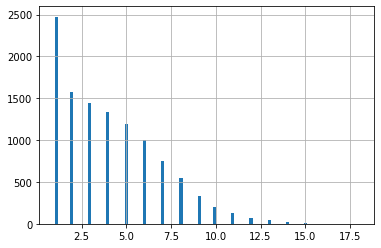

In [ ]:
rating_per_user = surprise_df.groupby('고객번호')['구매빈도'].count()

# 고객별 구매 제품 갯수
rating_per_user.hist(bins = 100);

In [ ]:
# 피벗테이블 만들기
rating_matrix = surprise_df.pivot_table(index='고객번호', columns='소분류명', values='구매빈도')

# 결측치 제거
rating_matrix = rating_matrix.fillna(0)
rating_matrix.shape

(11114, 38)

In [ ]:
rating_matrix

소분류명,global 편집샵,갤러리,건강식품,건강식품(비타민),건강식품(홍삼),남성해외패션,디자이너,디자이너부틱,디자이너캐릭터,명품기타,...,엘리든,음반,잡화멀티샵,조화,주얼리멀티,직수입,컨템포러리,피아노/악기,피혁,힐앤토트
고객번호,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,9.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,1.0,1.0,0.0,0.0,10.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,6.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19372,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19374,0.0,0.0,8.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19377,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
similar_users(1, rating_matrix)

[2619, 2380, 17559, 17632, 3070]

###0번 그룹

In [ ]:
# 추천 콘텐츠 뽑아내기

who = np.random.choice(clu0_li)
similar_user_indices = similar_users(who, rating_matrix)
recommend_content = recommend_item(who, similar_user_indices, rating_matrix)

print('고객번호: ', who )
print("-- 상품 추천 TOP 10 --")

# 모든 추천
print(recommend_content)

print('='*30)

# 2015년 4분기 총구매금액
clu0['구매일자'] = pd.to_datetime(clu0['구매일자'],format='%Y-%m-%d')
temp = clu0[clu0['구매일자'].between('2015-10-01', '2015-12-31')]
total = temp[temp['고객번호']==who]['구매금액'].sum()

# 추천상품 구매 시 고객의 구매정보 예측
print('##### 지출증가 예측치 #####')
for i in range(10):
  recommandation = recommend_content[i]
  code = df_merchant_cl[df_merchant_cl['소분류명']==recommandation]['소분류코드'].values[0]
  outcome = df_purchase_tr[df_purchase_tr['소분류코드']==code]['구매금액'].mean()
  pred = (total + outcome)/total
  print(f'추천상품 (평균구매금액): {recommandation} ({outcome})', ', 예상지출증가율 :', pred*100-100)

고객번호:  13114
-- 상품 추천 TOP 10 --
['시계' '숙녀고정행사' '건강식품(비타민)' '명품잡화' '어덜트' 'global 편집샵' '조화' '숙녀단기행사' '엘리든'
 '악기']
##### 지출증가 예측치 #####
추천상품 (평균구매금액): 시계 (377397.80535499397) , 예상지출증가율 : 15.611658980272011
추천상품 (평균구매금액): 숙녀고정행사 (77651.14293063534) , 예상지출증가율 : 3.2121627250087954
추천상품 (평균구매금액): 건강식품(비타민) (73202.81793132683) , 예상지출증가율 : 3.0281507039073574
추천상품 (평균구매금액): 명품잡화 (1287546.8157574623) , 예상지출증가율 : 53.2614167955565
추천상품 (평균구매금액): 어덜트 (783362.0239808153) , 예상지출증가율 : 32.40501296763128
추천상품 (평균구매금액): global 편집샵 (67323.55917771561) , 예상지출증가율 : 2.78494583780639
추천상품 (평균구매금액): 조화 (83669.56521739131) , 예상지출증가율 : 3.461124311448671
추천상품 (평균구매금액): 숙녀단기행사 (108317.84615384616) , 예상지출증가율 : 4.480739558198479
추천상품 (평균구매금액): 엘리든 (1135744.3203883495) , 예상지출증가율 : 46.98186573185143
추천상품 (평균구매금액): 악기 (827583.3333333334) , 예상지출증가율 : 34.23429758846589


###3번 그룹

In [ ]:
# 추천 콘텐츠 뽑아내기

who = np.random.choice(clu3_li)
similar_user_indices = similar_users(who, rating_matrix)
recommend_content = recommend_item(who, similar_user_indices, rating_matrix)

print('고객번호: ', who )
print("-- 상품 추천 TOP 10 --")

# 모든 추천
print(recommend_content)

print('='*30)

# 2015년 4분기 총구매금액
clu3['구매일자'] = pd.to_datetime(clu3['구매일자'],format='%Y-%m-%d')
temp = clu3[clu3['구매일자'].between('2015-10-01', '2015-12-31')]
total = temp[temp['고객번호']==who]['구매금액'].sum()

# 추천상품 구매 시 고객의 구매정보 예측
print('##### 지출증가 예측치 #####')
for i in range(10):
  recommandation = recommend_content[i]
  code = df_merchant_cl[df_merchant_cl['소분류명']==recommandation]['소분류코드'].values[0]
  outcome = df_purchase_tr[df_purchase_tr['소분류코드']==code]['구매금액'].mean()
  pred = (total + outcome)/total
  print(f'추천상품 (평균구매금액): {recommandation} ({outcome})', ', 예상지출증가율 :', pred*100-100)

고객번호:  19196
-- 상품 추천 TOP 10 --
['건강식품(홍삼)' '시계' '직수입' 'global 편집샵' '컨템포러리' '잡화멀티샵' '피아노/악기' '주얼리멀티' '음반'
 '명품잡화행사']
##### 지출증가 예측치 #####
추천상품 (평균구매금액): 건강식품(홍삼) (273813.0482442559) , 예상지출증가율 : 3.379740399973528
추천상품 (평균구매금액): 시계 (377397.80535499397) , 예상지출증가율 : 4.658312004480521
추천상품 (평균구매금액): 직수입 (281399.6884375721) , 예상지출증가율 : 3.4733841270560504
추천상품 (평균구매금액): global 편집샵 (67323.55917771561) , 예상지출증가율 : 0.830990905225093
추천상품 (평균구매금액): 컨템포러리 (1006213.046875) , 예상지출증가율 : 12.419929975251804
추천상품 (평균구매금액): 잡화멀티샵 (245536.61921708184) , 예상지출증가율 : 3.030717626358765
추천상품 (평균구매금액): 피아노/악기 (881778.8778877888) , 예상지출증가율 : 10.88400905855373
추천상품 (평균구매금액): 주얼리멀티 (169818.18181818182) , 예상지출증가율 : 2.0961067174160917
추천상품 (평균구매금액): 음반 (20996.464646464647) , 예상지출증가율 : 0.2591644199474672
추천상품 (평균구매금액): 명품잡화행사 (479686.41509433964) , 예상지출증가율 : 5.920884949816568
